In [228]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Define a weighting

In [132]:
lmax = 3000
l = np.arange(lmax+1)
beam = np.load('/mnt/home/ophilcox/ceph/planck_npipe/beam_planck1024.npy')[0][:lmax+1]
noise = np.load('/mnt/home/ophilcox/ceph/planck_npipe/Nl_spectra_planck1024_sevem.npy',allow_pickle=True).all()['TT'][:lmax+1]
with np.load('/mnt/home/ophilcox/ceph/planck_npipe/camb_transfer_ffp10_k0_isw_l2048.npz',allow_pickle=True) as tr:
    cl = tr['cls'].all()['total'][:lmax+1,0]

In [171]:
from scipy.interpolate import interp1d
chi_rec = 13882.607764400758
ratio_l = cl[2:]/(cl+noise/beam**2)[2:]
ratio_l = np.concatenate([[1],ratio_l,[0]])
ratio = interp1d(1./chi_rec*np.concatenate([[0],l[2:],[int(1e5)]]),ratio_l)

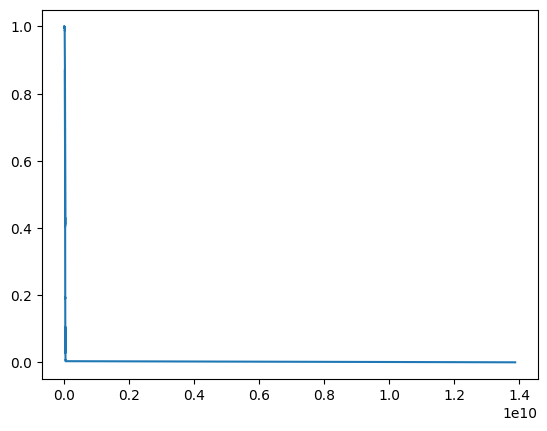

In [172]:
plt.plot(chi_rec*np.concatenate([[0],l[2:],[int(1e6)]]),ratio_l)

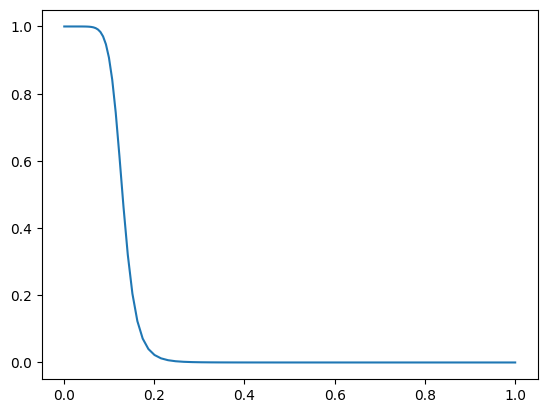

In [227]:
k_arr = np.logspace(-3,0,100)
#plt.semilogx(k_arr,ratio(k_arr))
plt.plot(k_arr,0.5*(1-np.tanh(10*np.log10(k_arr/0.13))))

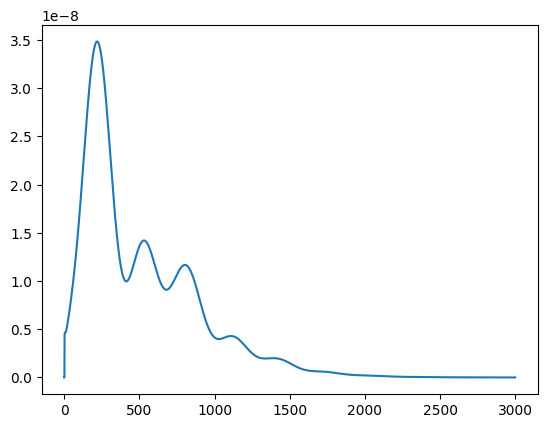

In [177]:
plt.plot(l,l**2*beam**2*cl+noise)

# Test loading functions


In [229]:
import numpy as np
import torch
import sys, os
sys.path.append(os.path.abspath('..'))

from sep_bk_nn import SepBKNN
from sep_bk_nn.bk_functions import create_bk_dataset

from sep_bk_nn.bk_functions import bk_function_equilateral, bk_function_slow_collider_minus_eq
from torch.utils.data import TensorDataset, DataLoader
#from torchsummary import summary
import matplotlib.pyplot as plt

In [230]:
#loaded_model = SepBKNN.load_model('../models/sl_collider/sep_bk_nn_test_3.pth', device=torch.device('cpu'))
# loaded_model = SepBKNN.load_model('models/checkpoint/best_model.pth', device=torch.device('cuda'))

In [231]:
model = 'collider'
log_transform = True
add_norm = False
kmin = 0.001
kmax = 1.0
symm_kind = 1
modelfile = '../models/oliver/sep_bk_nn_test_8.pth'

In [232]:
loaded_model = SepBKNN.load_model(modelfile, device=torch.device('cpu'))

alpha = loaded_model.model.alpha
beta = loaded_model.model.beta
if symm_kind == 1:
    gamma = loaded_model.model.gamma

print("Using %d terms"%len(alpha))

Model loaded from ../models/oliver/sep_bk_nn_test_8.pth
Using 5 terms


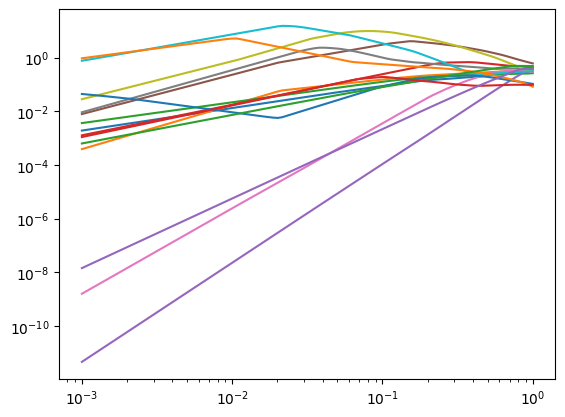

In [237]:
k_arr = np.geomspace(kmin,kmax,100, dtype=np.float32)
for j in range(len(alpha)):
    if log_transform:
        plt.plot(k_arr,[np.exp(alpha[j](torch.as_tensor(np.log(k_arr[i])).view(1).to('cpu')).detach().numpy()) for i in range(len(k_arr))])
        plt.plot(k_arr,[np.exp(beta[j](torch.as_tensor(np.log(k_arr[i])).view(1).to('cpu')).detach().numpy()) for i in range(len(k_arr))])
        if symm_kind == 1:
            plt.plot(k_arr,[np.exp(gamma[j](torch.as_tensor(np.log(k_arr[i])).view(1).to('cpu')).detach().numpy()) for i in range(len(k_arr))])
    else:
        plt.plot(k_arr,[alpha[j](torch.as_tensor(k_arr[i]).view(1).to('cpu')).detach().numpy() for i in range(len(k_arr))])
        plt.plot(k_arr,[beta[j](torch.as_tensor(k_arr[i]).view(1).to('cpu')).detach().numpy() for i in range(len(k_arr))])
        if symm_kind == 1:
            plt.plot(k_arr,[gamma[j](torch.as_tensor(k_arr[i]).view(1).to('cpu')).detach().numpy() for i in range(len(k_arr))])
plt.xscale('log')
plt.yscale('log')
# plt.plot(x_arr,1./x_arr)
# plt.plot(x_arr,x_arr**2)

In [238]:
def get_model(test_k1,test_k2,test_k3):
    test_k1 = torch.as_tensor(test_k1).view(1).to('cpu')
    test_k2 = torch.as_tensor(test_k2).view(1).to('cpu')
    test_k3 = torch.as_tensor(test_k3).view(1).to('cpu')

    weights_list = loaded_model.model.weights
    test_result = 0.
    norm_result = 0.

    def t(x):
        if log_transform:
            return torch.exp(x)
        else:
            return x
    def g(x):
        if log_transform:
            return torch.log(x)
        else:
            return x

    for i in range(len(alpha)):
        if symm_kind==1:
            alpha_k1 = t(alpha[i](g(test_k1)))
            alpha_k2 = t(alpha[i](g(test_k2)))
            alpha_k3 = t(alpha[i](g(test_k3)))

            beta_k1  = t(beta[i](g(test_k1)))
            beta_k2  = t(beta[i](g(test_k2)))
            beta_k3  = t(beta[i](g(test_k3)))

            gamma_k1 = t(gamma[i](g(test_k1)))
            gamma_k2 = t(gamma[i](g(test_k2)))
            gamma_k3 = t(gamma[i](g(test_k3)))

            test_result += weights_list[i]*(alpha_k1*beta_k2*gamma_k3 + alpha_k2*beta_k3*gamma_k1 + alpha_k3*beta_k1*gamma_k2 + alpha_k1*beta_k3*gamma_k2 + alpha_k2*beta_k1*gamma_k3 + alpha_k3*beta_k2*gamma_k1)
            if add_norm:
                alpha0 = t(alpha[i](g(torch.ones(1))))
                beta0  = t(beta[i](g(torch.ones(1))))
                gamma0  = t(gamma[i](g(torch.ones(1))))
                norm_result += 6*weights_list[i]*(alpha0*beta0*gamma0)

        if symm_kind==2:
            alpha_k1 = t(alpha[i](g(test_k1)))
            alpha_k2 = t(alpha[i](g(test_k2)))
            alpha_k3 = t(alpha[i](g(test_k3)))

            beta_k1  = t(beta[i](g(test_k1)))
            beta_k2  = t(beta[i](g(test_k2)))
            beta_k3  = t(beta[i](g(test_k3)))

            test_result += weights_list[i]*(alpha_k1*beta_k2*beta_k3 + alpha_k2*beta_k3*beta_k1 + alpha_k3*beta_k1*beta_k2)
            if add_norm:
                alpha0 = t(alpha[i](g(torch.ones(1))))
                beta0  = t(beta[i](g(torch.ones(1))))
                norm_result += 3*weights_list[i]*(alpha0*beta0**2)
       
    if add_norm:
        return test_result.detach().numpy()/norm_result.detach().numpy()
    else:
        return test_result.detach().numpy()

In [239]:
if model=='collider':
    def get_true_model(k1,k2,k3, alpha=0.1):
        return   (k1**2/k2/k3) / (1. + (alpha*k1**2/k2/k3)**2) / 3\
                +(k2**2/k1/k3) / (1. + (alpha*k2**2/k1/k3)**2) / 3\
                +(k3**2/k1/k2) / (1. + (alpha*k3**2/k1/k2)**2) / 3
elif model=='eq':
    def get_true_model(k1, k2, k3):
        return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2)\
             - (k1**2 / (k2 * k3) + k2**2 / (k1 * k3) + k3**2 / (k1 * k2)) - 2
elif model=='loc':
    def get_true_model(k1, k2, k3):
        return (k1**2 / (k2 * k3) + k2**2 / (k1 * k3) + k3**2 / (k1 * k2))/3.
else:
    raise Exception()

In [240]:
# Define the triangles
nT = 50
nK = 10
power = 1
x_min = kmin/kmax
x = np.linspace(x_min**power,1**power,nT)**(1./power)
y = np.linspace(x_min**power,1**power,nT)**(1./power)
k = np.geomspace(kmin, kmax, nK)
XX, YY, KK = np.meshgrid(x,y,k)
f = (np.abs(XX-YY)<=1.)*(1.<=XX+YY)*(XX<=YY)*(KK*XX>=kmin)*(KK*YY>=kmin)
xx = XX[f].ravel()
yy = YY[f].ravel()
kk = KK[f].ravel()
# # Add edges
# for y in np.unique(yy):
#     if 1-y<x_min:
#         xx = np.append(xx,[y])
#         yy = np.append(yy,[y])
#     else:
#         xx = np.append(xx,[1-y,y])
#         yy = np.append(yy,[y,y])
# xx = np.append(xx,[0.5,1.0])
# yy = np.append(yy,[0.5,1.0])

shapes_nn = np.zeros_like(XX)
shapes_true = np.zeros_like(XX)
shapes_nn[f] = np.asarray([get_model((kk[i]*xx[i]).astype(np.float32),(kk[i]*yy[i]).astype(np.float32),kk[i].astype(np.float32)) for i in range(len(xx))]).ravel()
shapes_true[f] = np.asarray([get_true_model((kk[i]*xx[i]).astype(np.float32),(kk[i]*yy[i]).astype(np.float32),kk[i].astype(np.float32)) for i in range(len(xx))])

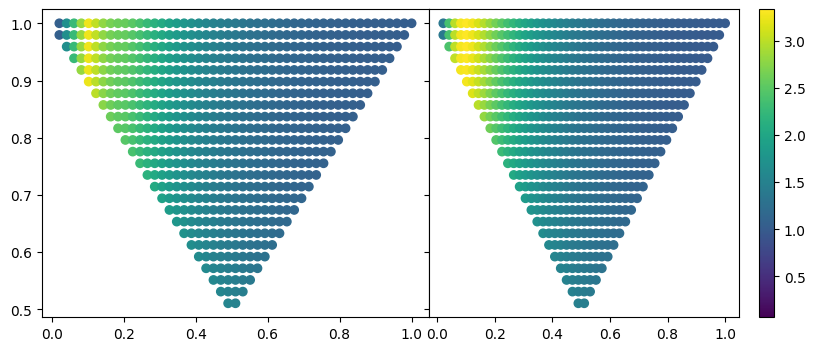

In [250]:
filt = kk==np.unique(kk)[6]
fig, ax = plt.subplots(1,2, figsize=(10,4),sharex=True, sharey=True)
minval, maxval = np.min(shapes_true[f]),np.max(shapes_true[f])
ax[0].scatter(xx[filt],yy[filt],c=shapes_nn[f][filt],vmax=maxval,vmin=minval)
cax=ax[1].scatter(xx[filt],yy[filt],c=shapes_true[f][filt],vmax=maxval,vmin=minval)
fig.subplots_adjust(wspace=0)
fig.colorbar(cax);

In [242]:
from scipy.integrate import simpson
def inner(shape1, shape2):
    return simpson(k**2*simpson(simpson(shape1*shape2*f,x=x,axis=0),x=y,axis=0),x=k,axis=0)

In [243]:
inner_nn = inner(shapes_nn, shapes_nn)
inner_nt = inner(shapes_nn, shapes_true)
inner_tt = inner(shapes_true, shapes_true)
cos = inner_nt/np.sqrt(inner_nn*inner_tt)
print("Cosine: %.6f"%cos)

Cosine: 0.999958


### Testing

In [59]:
# Full script for separable symbolic regression of S_eq shape function

import numpy as np
import itertools
import matplotlib.pyplot as plt
from tensorly.decomposition import tucker#parafac
import tensorly as tl
from pysr import PySRRegressor

# Set up TensorLy
tl.set_backend('numpy')

# Step 1: Generate k grid and triangle configurations
k_vals = np.logspace(-3, 0, 30)
K1, K2, K3 = np.meshgrid(k_vals, k_vals, k_vals, indexing='ij')

def triangle_mask(k1, k2, k3):
    cond1 = np.abs(k1 - k2) <= k3
    cond2 = k1+k2>=k3
    return cond1 & cond2

mask = triangle_mask(K1, K2, K3)

# Equilateral shape function
print('loc')
def S_eq(k1, k2, k3):
    term1 = k1/k2 + k2/k3 + k3/k1 + k2/k1 + k3/k2 + k1/k3
    term2 = k1**2 / (k2 * k3) + k2**2 / (k3 * k1) + k3**2 / (k1 * k2)
    return term2
    #return term1 - term2 - 2

S_vals = S_eq(K1, K2, K3)
S_vals_masked = S_vals * mask

# Step 2: CP decomposition
core, factors = tucker(S_vals_masked, rank=[1, 1, 1], mask=mask)  
factors_k1, factors_k2, factors_k3 = factors

#assert np.allclose(factors_k1, factors_k2) and np.allclose(factors_k2, factors_k3), "Decomposition not symmetric"

#basis_functions = factors_k1 * weights

loc


In [60]:
BB = np.einsum('abc,ia,jb,kc->ijk',core,factors_k1,factors_k2,factors_k3)

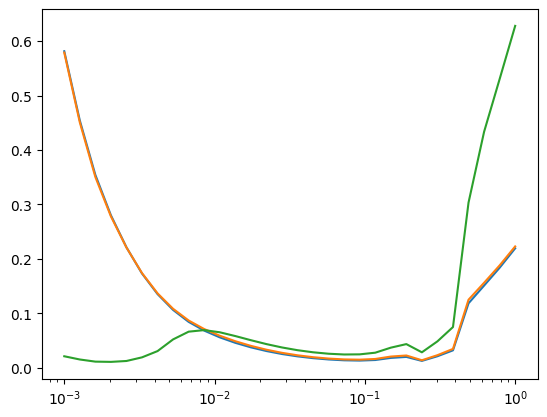

In [64]:
plt.plot(k_vals,factors_k1)
plt.plot(k_vals,factors_k2)
plt.plot(k_vals,factors_k3)
plt.xscale('log')

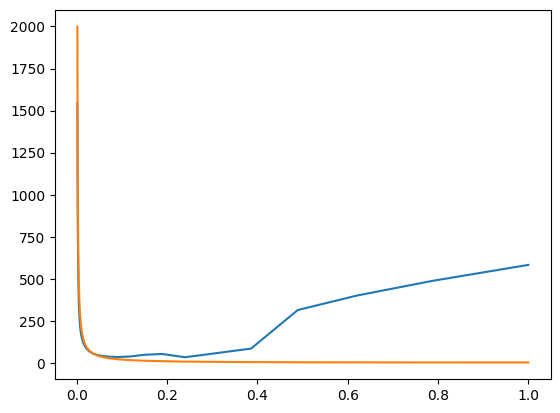

In [61]:
plt.plot(K1[:,-1,-1],BB[:,-1,-1])
plt.plot(K1[:,-1,-1],S_vals_masked[:,-1,-1])

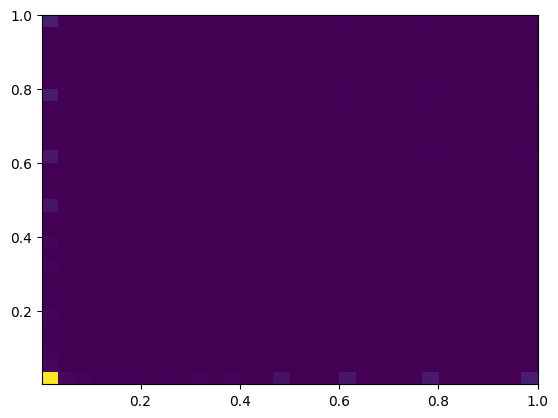

In [57]:
Km = np.max([K1,K2,K3],0)
plt.hist2d(K1[:,:,-1].ravel(),K2[:,:,-1].ravel(),weights=BB[:,:,-1].ravel(),bins=30);

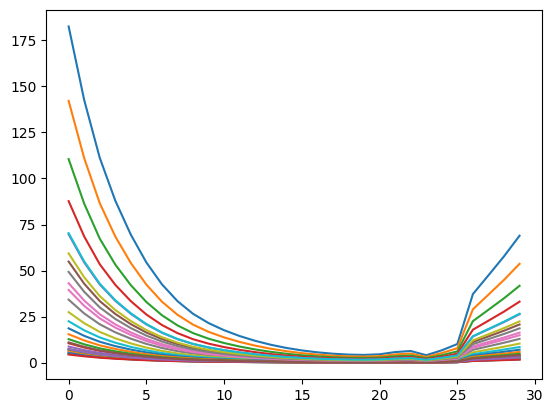

In [58]:
plt.plot(BB[:,:,23]);

/mnt/home/ophilcox/mpivenv2/lib/python3.9/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Using features ['x0']
/mnt/home/ophilcox/mpivenv2/lib/python3.9/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Using features ['x0']
/mnt/home/ophilcox/mpivenv2/lib/python3.9/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Using features ['x0']
/mnt/home/ophilcox/mpivenv2/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PySRRegressor was fitted with feature names
  warnings.warn(
/mnt/home/ophilcox/mpivenv2/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PySRRegressor was fitted with feature names
  w

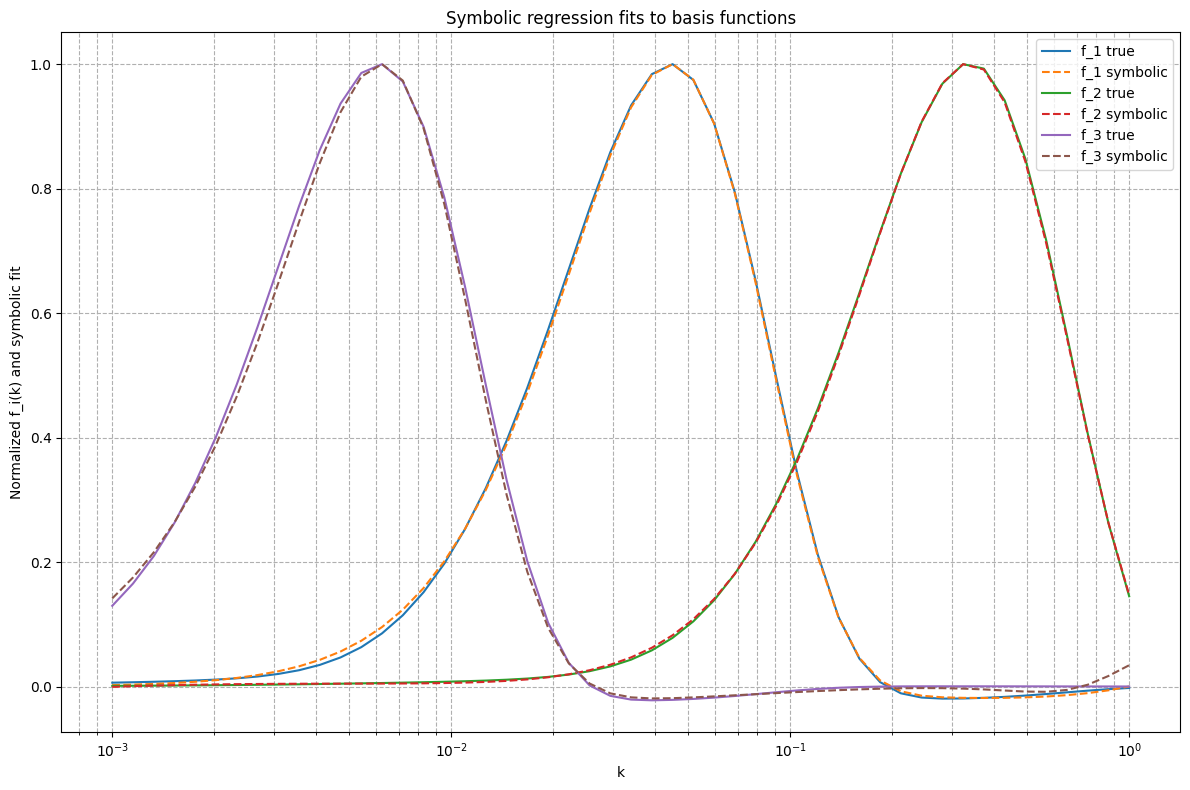

f_1(k) symbolic expression:
complexity                                                      23
loss                                                      0.000699
equation         ((log(x0) * x0) * 0.2963196) + exp((((x0 * -2....
score                                                     0.605031
sympy_format     0.2963196*x0*log(x0) + exp((3.06843437125172*l...
lambda_format    PySRFunction(X=>0.2963196*x0*log(x0) + exp((3....
Name: 13, dtype: object
f_2(k) symbolic expression:
complexity                                                      22
loss                                                      0.000117
equation         ((x0 + -0.014714854) * (((exp((x0 - (1.9493161...
score                                                      0.30735
sympy_format     (x0 - 0.014714854)*(x0*(exp((x0 - (1.9493161 -...
lambda_format    PySRFunction(X=>(x0 - 0.014714854)*(x0*(exp((x...
Name: 17, dtype: object
f_3(k) symbolic expression:
complexity                                                      

In [63]:
# Step 3: Symbolic regression for each basis function

symbolic_models = []
for i in range(rank):
    y = basis_functions[:, i]
    X = k_vals.reshape(-1, 1)

    model = PySRRegressor(
        niterations=200,
        binary_operators=["+", "-", "*", "/"],
        unary_operators=["exp", "log", "sqrt"],#, "inv(x)", "x^2", "x^3"],
        #extra_sympy_mappings={"inv": lambda x: 1/x},
        select_k_features=1,
        #elementwise_loss="loss(x, y) = (x - y)^2",
        model_selection="best",
        verbosity=0,
    )

    model.fit(X, y)
    symbolic_models.append(model)

# Step 4: Plot symbolic fits and report expressions
plt.figure(figsize=(12, 8))
for i, model in enumerate(symbolic_models):
    y_pred = model.predict(k_vals.reshape(-1,1))
    plt.plot(k_vals, basis_functions[:, i]/np.max(np.abs(basis_functions[:, i])), label=f"f_{i+1} true")
    plt.plot(k_vals, y_pred/np.max(np.abs(y_pred)), '--', label=f"f_{i+1} symbolic")
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('Normalized f_i(k) and symbolic fit')
plt.legend()
plt.title('Symbolic regression fits to basis functions')
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

# Step 5: Print discovered symbolic expressions
for i, model in enumerate(symbolic_models):
    print(f"f_{i+1}(k) symbolic expression:")
    print(model.get_best())

In [12]:
kmin = 0.001
kmax = 1.0
n_points_k = 100

In [47]:
k_arr = np.geomspace(kmin, kmax, n_points_k)
points = []
for k1 in k_arr:
    for k2 in k_arr:
        for k3 in k_arr:
            if np.abs(k1-k2)<=k3 and k3<=k1+k2:# and k1<=k2 and k2<=k3:
                points.append([k1,k2,k3])
points = np.asarray(points)
print("Using %d points"%len(points))

def get_S_eq(k1, k2, k3):
    return (k1/k2 + k2/k1 + k1/k3 + k3/k1 + k2/k3 + k3/k2) - (k1**2 / (k2 * k3) + k2**2 / (k1 * k3) + k3**2 / (k1 * k2)) - 2

def get_S_loc(k1, k2, k3):
        return (k1**2 / (k2 * k3) + k2**2 / (k1 * k3) + k3**2 / (k1 * k2))/3.
S_loc = get_S_loc(points[:,0],points[:,1],points[:,2])

Using 84751 points


In [48]:
import tensorly as tl
from tensorly.decomposition import tucker

# Construct a 3D tensor S_tensor from the provided data
# This step requires discretizing the range of k1, k2, k3 and accumulating S_data into a 3D grid.
def construct_tensor(k_data, S_data, bins=100):
    # Create a 3D histogram
    hist, edges = np.histogramdd(k_data, bins=bins, weights=S_data)
    return hist, edges 

S_tensor, edges = construct_tensor(points, S_loc)

# Tucker Decomposition
core, factors = tucker(S_tensor, rank=[1, 1, 1])  # specify the rank according to problem requirements

# Factors corresponds to f_i, g_i, h_i
factors_f = factors[0]
factors_g = factors[1]
factors_h = factors[2]

# print("Core tensor:\n", core)
# print("Factor matrices:")
# print("f_i factors:\n", factors_f)
# print("g_i factors:\n", factors_g)
# print("h_i factors:\n", factors_h)

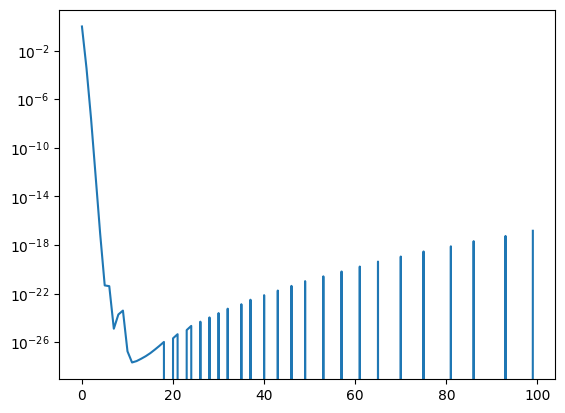

In [54]:
plt.semilogy(factors_f*factors_g*factors_h)

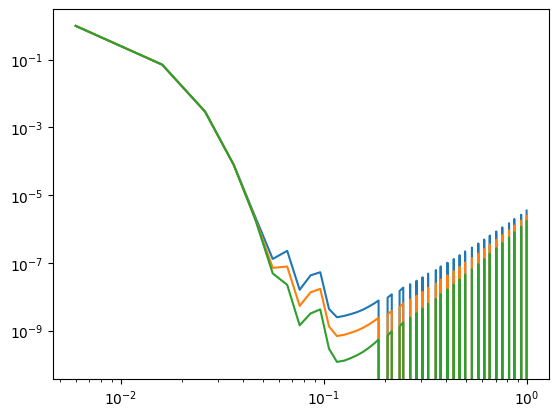

In [49]:
k_av = np.asarray(edges)
k_av = (k_av[:,1:]+k_av[:,:-1])/2.
plt.plot(k_av[0],factors_f)
plt.plot(k_av[0],factors_g)
plt.plot(k_av[0],factors_h)
plt.yscale('log')
plt.xscale('log')

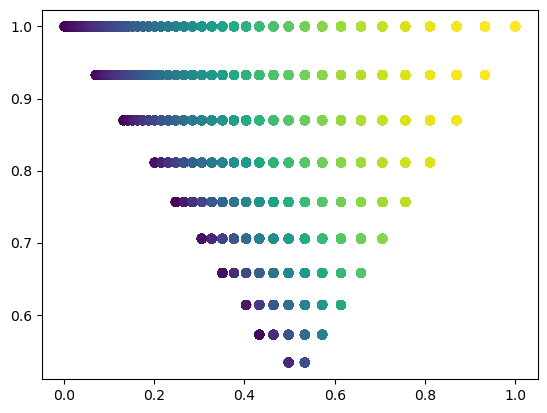

In [72]:
plt.scatter(points[:,0]/points[:,2],points[:,1]/points[:,2],c=S_eq)

In [119]:
def inner(iint1, iint2):
    return simpson(simpson(iint1*iint2*(np.abs(x_arr-y_arr)<=1)*(1<=x_arr+y_arr)*(x_arr<=y_arr), x=x_arr[0], axis=0), x=y_arr[:,0]), x=k_arr[:,0])
inner_nn = inner(iint_nn, iint_nn)
inner_nt = inner(iint_nn, iint_true)
inner_tt = inner(iint_true, iint_true)

SyntaxError: unmatched ')' (1366213182.py, line 2)

In [401]:
from scipy.interpolate import LinearNDInterpolator
_interp_nn = LinearNDInterpolator(np.asarray([xx,yy]).T,shapes_nn, 0.)

def interp_nn(_x,_y):
    x = np.min([_x,_y],0)
    y = np.max([_x,_y],0)
    filt = (np.abs(x-y)<=1)*(1<=x+y)*(x<=y)
    out = np.zeros_like(x)
    out[filt] = _interp_nn(x[filt],y[filt])
    return out
def interp_true(_x,_y):
    x = np.min([_x,_y],0)
    y = np.max([_x,_y],0)
    filt = (np.abs(x-y)<=1)*(1<=x+y)*(x<=y)
    out = np.zeros_like(x)
    z = np.ones_like(x)
    out[filt] = get_true_model(x[filt],y[filt], z[filt])
    return out

x_arr = np.linspace(x_min,1,100)[None,:]
y_arr = np.linspace(x_min,1,100)[:,None]
x_arr = x_arr + 0.*y_arr
y_arr = y_arr + 0.*x_arr
from scipy.integrate import simpson
iint_nn = interp_nn(np.min([x_arr,y_arr],0),np.max([x_arr,y_arr],0))
iint_true = interp_true(np.min([x_arr,y_arr],0),np.max([x_arr,y_arr],0))

In [402]:
def inner(iint1, iint2):
    return simpson(simpson(iint1*iint2*(np.abs(x_arr-y_arr)<=1)*(1<=x_arr+y_arr)*(x_arr<=y_arr), x=x_arr[0], axis=0), x=y_arr[:,0]), x=k_arr[:,0])
inner_nn = inner(iint_nn, iint_nn)
inner_nt = inner(iint_nn, iint_true)
inner_tt = inner(iint_true, iint_true)

In [403]:
cos_nt = inner_nt/np.sqrt(inner_nn*inner_tt)
print(cos_nt)

0.9999941950934313


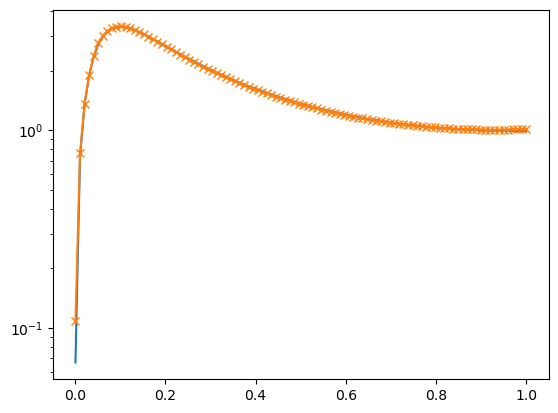

In [404]:
y_test = np.unique(yy)[-1]
plt.plot(xx[yy==y_test],shapes_true[yy==y_test])
plt.plot(xx[yy==y_test],shapes_nn[yy==y_test],marker='x')
plt.yscale('log')

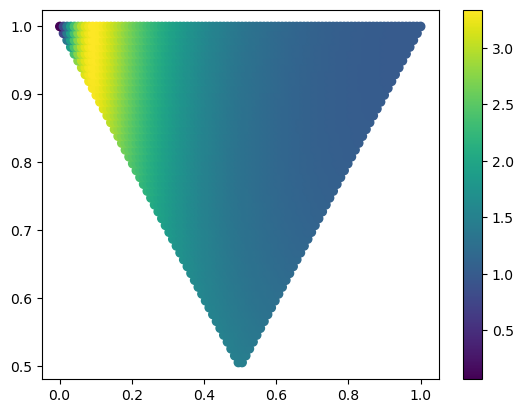

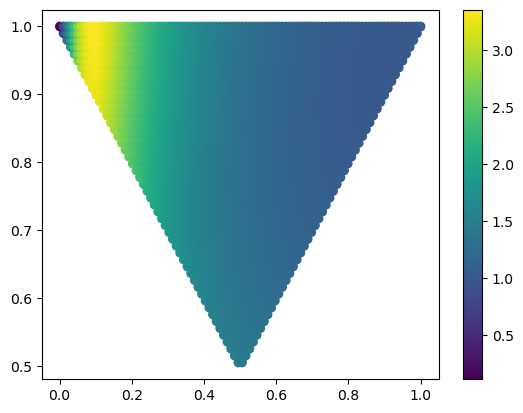

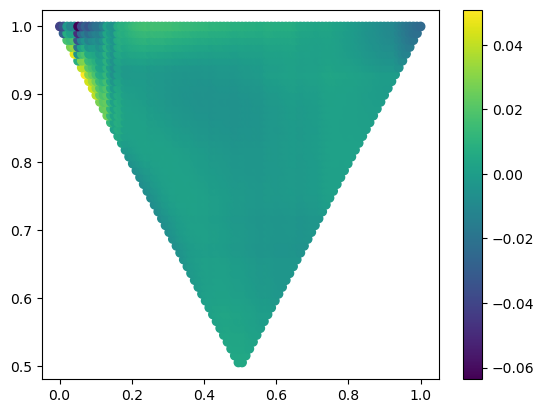

In [405]:
plt.scatter(xx,yy,c=shapes_true)
plt.colorbar()

plt.figure()
plt.scatter(xx,yy,c=shapes_nn)
plt.colorbar()


plt.figure()
plt.scatter(xx,yy,c=shapes_true-shapes_nn)
plt.colorbar()

In [7]:
alpha

ModuleList(
  (0-1): 2 x MLP(
    (net): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [3]:
# BK_FUNC = 'bk_eq'
# FUN_ARG = None
# bk_function = bk_function_equilateral

BK_FUNC = 'bk_sl_collider'
FUN_ARG = {'alpha': 0.1}
bk_function = bk_function_slow_collider_minus_eq
    
NUM_TERMS = 2
SYMM_KIND = 2
KMIN = 0.008

batch_size = 512

X_test, y_test = create_bk_dataset(grid_points=1000, func_name=BK_FUNC,\
                                   func_arg=FUN_ARG, scale_invariant=True, k2_sample_version=2)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [4]:
loaded_model.evaluate((test_loader))

1.1985986431904038e-05

In [5]:
loaded_model.test_mse((test_loader))

Test Mean Squared Error: 0.000012


1.1985986431904038e-05

In [6]:
alpha = loaded_model.model.alpha
beta = loaded_model.model.beta


In [7]:
### if you want to see some weights

# for name, param in alpha[1].named_parameters():
#     if param.requires_grad:  # Only print parameters that are trainable
#         print(f"Layer: {name}, Weights: {param.data}")

In [8]:
weights_list = loaded_model.model.weights
print(weights_list[0], weights_list[1])

tensor(0.3769, device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3900, device='cuda:0', grad_fn=<SelectBackward0>)


In [9]:
print('========== alpha summary ========')
summary(alpha[0], [[1,1,1]])

print('========== beta summary ========')
summary(beta[0], [[1,1,1]])

========== alpha summary ========
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1, 1, 128]             256
              ReLU-2            [-1, 1, 1, 128]               0
            Linear-3             [-1, 1, 1, 64]           8,256
              ReLU-4             [-1, 1, 1, 64]               0
            Linear-5              [-1, 1, 1, 1]              65
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
========== beta summary ========
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1, 1,

In [10]:
# alpha[0].to('cpu')
# beta[0].to('cpu')
# weights_list[0].to('cpu')

In [11]:
test_k_val = [0.8018, 0.9012, 1.0000]
test_k1 = test_k_val[0]
test_k2 = test_k_val[1]
test_k3 = test_k_val[2]

test_k_val = torch.as_tensor(test_k_val).to('cuda')
test_k1 = torch.as_tensor(test_k1).view(1).to('cuda')
test_k2 = torch.as_tensor(test_k2).view(1).to('cuda')
test_k3 = torch.as_tensor(test_k3).view(1).to('cuda')


In [12]:
test_result = 0.

for i in range(2):

    alpha_k1 = alpha[i](test_k1)
    beta_k2  = beta[i](test_k2)
    beta_k3  = beta[i](test_k3)

    alpha_k2 = alpha[i](test_k2)
    beta_k1  = beta[i](test_k1)
    beta_k2  = beta[i](test_k2)

    alpha_k3 = alpha[i](test_k3)
    beta_k1  = beta[i](test_k1)
    beta_k2  = beta[i](test_k2)

    test_result += weights_list[i]*(alpha_k1*beta_k2*beta_k3 + alpha_k3*beta_k1*beta_k2 + alpha_k3*beta_k1*beta_k2)

print(test_result)

tensor([1.0411], device='cuda:0', grad_fn=<AddBackward0>)


In [13]:
bk_function(test_k_val[0],test_k_val[1],test_k_val[2])

tensor(1.0234, device='cuda:0')

# plot differences along k1=k2

In [14]:
def get_bk_k1_k2(k1k2=0.1):
    # get the bk from the NN with k1=k2
    result = 0.
    for i in range(2):
        tmp1 = alpha[i](k1k2)
        tmp2  = beta[i](k1k2)
        tmp3  = beta[i](test_k3)

        tmp4 = alpha[i](k1k2)
        tmp5  = beta[i](k1k2)
        tmp6  = beta[i](test_k2)

        tmp7 = alpha[i](test_k3)
        tmp8  = beta[i](k1k2)
        tmp9  = beta[i](k1k2)
        result += weights_list[i]*(tmp1*tmp2*tmp3 + tmp4*tmp5*tmp6 + tmp7*tmp8*tmp9)
    return result

In [15]:
test_k1k2 = np.linspace(0.51, 1., 100).astype(float)
test_result_k1k2 = []
for k1k2 in test_k1k2:
    k1k2 = torch.as_tensor(k1k2).view(1).to('cuda').float()
    test_result_k1k2.append(get_bk_k1_k2(k1k2).detach().cpu().numpy()[0])
test_result_k1k2 = np.array(test_result_k1k2)


true_result_k1k2 = []
for k1k2 in test_k1k2:
    true_result_k1k2.append(bk_function(k1k2, k1k2, 1.0))
    
true_result_k1k2 = np.array(true_result_k1k2)

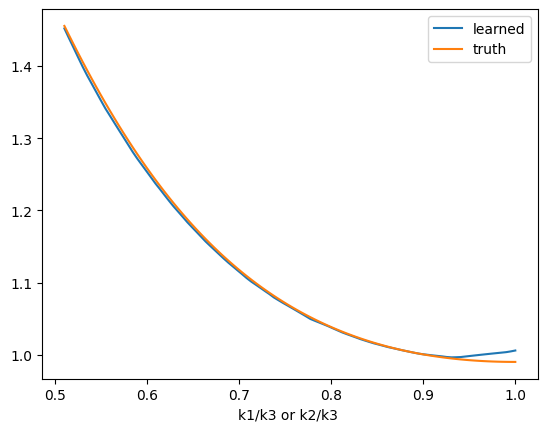

mean of abs residual 0.0033170229805758113


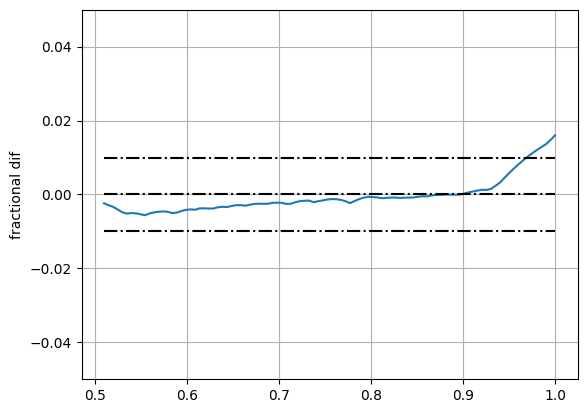

In [16]:
plt.plot(test_k1k2, test_result_k1k2, label='learned')
plt.plot(test_k1k2, true_result_k1k2, label='truth')

plt.xlabel('k1/k3 or k2/k3 ')
plt.legend()
plt.show()

plt.plot(test_k1k2, test_result_k1k2/true_result_k1k2-1)
plt.ylabel('fractional dif')
plt.ylim(-0.05, 0.05)

plt.plot(test_k1k2, 0.01*np.ones(test_k1k2.shape[0]), ls='-.', c='black')
plt.plot(test_k1k2, -0.01*np.ones(test_k1k2.shape[0]), ls='-.', c='black')
plt.plot(test_k1k2, 0.*np.ones(test_k1k2.shape[0]), ls='-.', c='black')

plt.grid()

print('mean of abs residual', np.mean(np.abs(test_result_k1k2/true_result_k1k2-1)))

# plot differences along k1, fixe k2=k3=1.

In [17]:
def get_bk_squeezed(k1k2=0.1):
    # get the bk from the NN with k1=k2
    result = 0.
    for i in range(2):
        tmp1 = alpha[i](k1k2)
        tmp2  = beta[i](test_k3)
        tmp3  = beta[i](test_k3)

        tmp4 = alpha[i](test_k3)
        tmp5  = beta[i](k1k2)
        tmp6  = beta[i](test_k2)

        tmp7 = alpha[i](test_k3)
        tmp8  = beta[i](test_k3)
        tmp9  = beta[i](k1k2)
        result += weights_list[i]*(tmp1*tmp2*tmp3 + tmp4*tmp5*tmp6 + tmp7*tmp8*tmp9)
    return result

In [18]:
test_k1k2 = np.linspace(0.01, 1., 100).astype(float)
test_result_k1k2 = []
for k1k2 in test_k1k2:
    k1k2 = torch.as_tensor(k1k2).view(1).to('cuda').float()
    test_result_k1k2.append(get_bk_squeezed(k1k2).detach().cpu().numpy()[0])
test_result_k1k2 = np.array(test_result_k1k2)


true_result_k1k2 = []
for k1k2 in test_k1k2:
    true_result_k1k2.append(bk_function(k1k2, 1.0, 1.0))
    
true_result_k1k2 = np.array(true_result_k1k2)

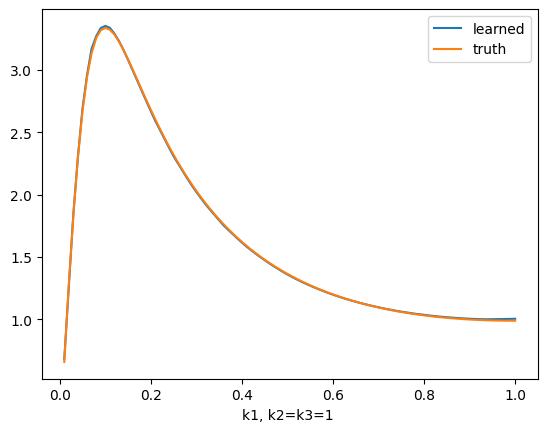

mean of abs residual 0.004446592565214514


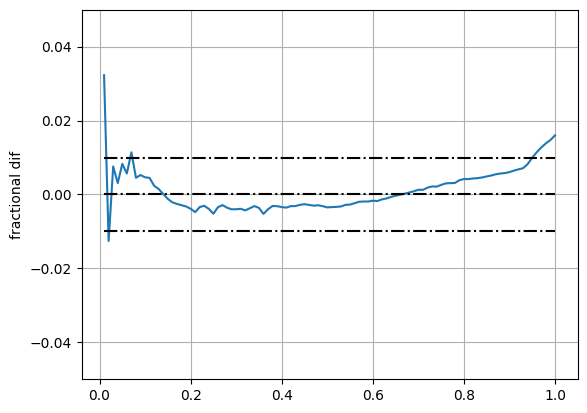

In [19]:
plt.plot(test_k1k2, test_result_k1k2, label='learned')
plt.plot(test_k1k2, true_result_k1k2, label='truth')

plt.xlabel('k1, k2=k3=1 ')
plt.legend()
plt.show()

plt.plot(test_k1k2, test_result_k1k2/true_result_k1k2-1)
plt.ylabel('fractional dif')
plt.ylim(-0.05, 0.05)

plt.plot(test_k1k2, 0.01*np.ones(test_k1k2.shape[0]), ls='-.', c='black')
plt.plot(test_k1k2, -0.01*np.ones(test_k1k2.shape[0]), ls='-.', c='black')
plt.plot(test_k1k2, 0.*np.ones(test_k1k2.shape[0]), ls='-.', c='black')

plt.grid()

print('mean of abs residual', np.mean(np.abs(test_result_k1k2/true_result_k1k2-1)))

In [20]:
weights_list

Parameter containing:
tensor([0.3769, 0.3900], device='cuda:0', requires_grad=True)

# 3d Plot

In [21]:
def plot_3d_data(xy_vals, bk, method='scatter', title='3D Plot'):
    """
    Plot 3D data with color mapping
    
    Args:
        k_vals: array of shape (N, 2) containing x and y coordinates
        bk: array of shape (N,) containing z values
        method: 'scatter' or 'surface'
        title: plot title
    """
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection='3d')
    
    # Set viewing angle
    ax.azim = -75
    ax.dist = 10
    ax.elev = 30
    
    x = xy_vals[:, 0]
    y = xy_vals[:, 1]
    z = bk.flatten()
    
    if method == 'scatter':
        # Create scatter plot with color mapping
        scatter = ax.scatter3D(x, y, z, 
                             c=z,  # Color by z value
                             cmap='viridis',  # Choose colormap
                             s=30,  # Marker size
                             alpha=0.6)  # Transparency
        
        # Add colorbar
        fig.colorbar(scatter, ax=ax, label='Z Value')
        
    elif method == 'surface':
        # Create triangulation surface plot
        surf = ax.plot_trisurf(x, y, z,
                             cmap='viridis',
                             alpha=0.8)
        
        # Add colorbar
        fig.colorbar(surf, ax=ax, label='Z Value')
    
    # Labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    
    # Set axis limits if needed
    # ax.set_xlim([x.min(), x.max()])
    # ax.set_ylim([y.min(), y.max()])
    # ax.set_zlim([z.min(), z.max()])
    
    plt.show()

/tmp/ipykernel_1207582/485922144.py:16: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 10


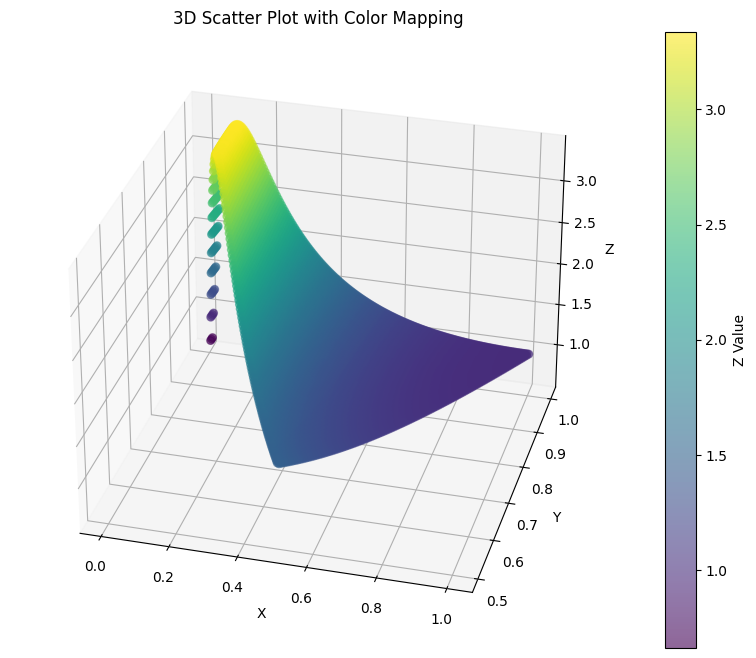

In [22]:
k_vals, bk = create_bk_dataset(grid_points=200, func_name=BK_FUNC, func_arg=FUN_ARG, scale_invariant=True)
# Generate sample data
n_points = k_vals.shape[0]
x = k_vals[:,0]
y = k_vals[:,1]
z = bk.flatten()

xy_vals = np.column_stack((x, y))

# Create both types of plots
plot_3d_data(xy_vals, z, method='scatter', title='3D Scatter Plot with Color Mapping')


In [23]:
bk_predicted = loaded_model.model(k_vals.to('cuda'))
diff = z-bk_predicted.detach().cpu().numpy().flatten()

print('mean of the diff is: ',   np.mean(np.abs(diff.numpy())) )

mean of the diff is:  0.0019019053


/tmp/ipykernel_1207582/485922144.py:16: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 10


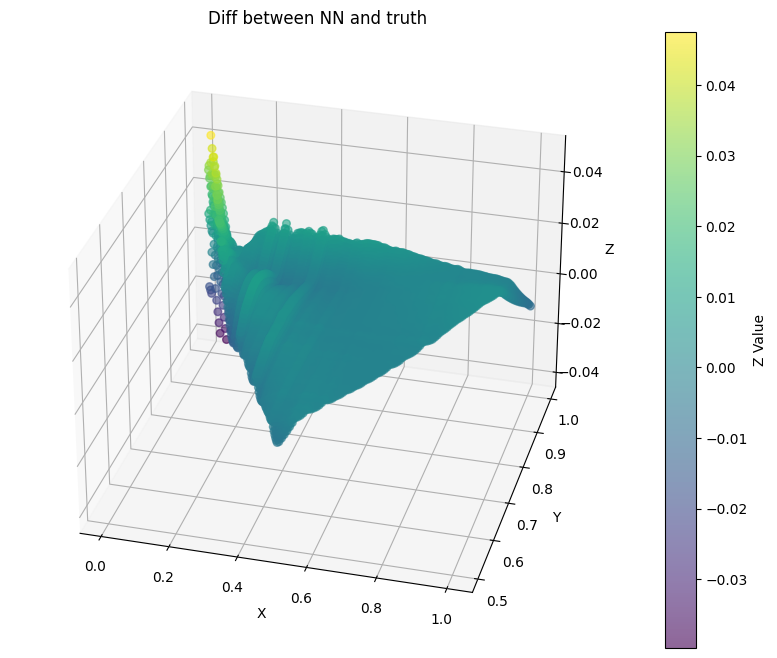

In [24]:
plot_3d_data(xy_vals, diff, method='scatter', title='Diff between NN and truth')


In [25]:
# Delta fNL

loaded_model.get_Delta_fNL(test_loader, KMIN)

/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/integrate/_quadpack_py

Calculating the inner product with interpolation
true <B|B> is 0.6605076091947527
The bias estimation of fNL is approximately Delta_fNL =  0.002100305241405876


4.411282107076995e-06

In [25]:
# Delta fNL

loaded_model.get_Delta_fNL(test_loader, KMIN, method = 'direct_sum')

Please ensure the k samples are uniform in order to use direct sum
The bias estimation of fNL is approximately Delta_fNL =   0.0021286291770256055


0.0021286291770256055